#  CODE for DARIAH 2025 EVALUATION

# 1.- SETUP

In [ ]:
!pip install openpyxl
!pip3 install numpy
!pip3 install scipy

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory


In [5]:
import pandas as pd
import nervaluate
import ast
from nervaluate import Evaluator
import re

In [6]:
valores=[
'chain_of_thought',
'few_shot',
'one_shot']

#'chain_of_thought_FS',

In [7]:
valores_a_modificar={
        "I-WEATHER_PHENOMENA":'I-WEATHER',
        "I-BIOMES": "I-BIOME", 
        "I-MYTHOLOGICAL_ENTITIES":'I-MYTH',
        "I-HUMAN_LANDFORM": 'I-HUM_LANDFORM',
        "I-NATURAL_LANDFORM": 'I-NAT_LANDFORM',
        "I-NATURAL_PHENOMENON":'I-NAT_PHENOMENON',
        "B-WEATHER_PHENOMENA":'B-WEATHER',
        "B-BIOMES": "B-BIOME", 
        "B-MYTHOLOGICAL_ENTITIES":'B-MYTH',
        "B-HUMAN_LANDFORM": 'B-HUM_LANDFORM',
        "B-NATURAL_LANDFORM": 'B-NAT_LANDFORM',
        "B-NATURAL_PHENOMENON":'B-NAT_PHENOMENON',
        }

In [9]:
#ESTO SOLO SE DEBE EJECUTAR SINO TENGO LOS VALORES NORMALIZADOS ES DECIR HE QUITADO TODOS LOS ERROREES DEL MODELO QUE PRODUCIAN SALIDA NAN.
#SOLO SE EJECutA UNA VEZ SI ES NECESARIO
path='/Users/salvador/GitHub/absa-travelogues _deepseek/ABSA_data_results_deepseek/'
path1='/Users/salvador/GitHub/absa-travelogues _deepseek/ABSA_data_clean/'
eliminar=[]
for valor in valores:
    res_ok=pd.read_csv(path+f'{valor}_english_fin_ok.csv')
    cuenta=0
    total=0

#True is the gold labels
    for item in res_ok["CAT_ASPECT"]:
        if not isinstance(item, str):
            total=total+1
            #print(f"Elemento inesperado: {item} (tipo: {type(item)})")
            #print(cuenta)
            if cuenta not in(eliminar):
                eliminar.append(cuenta)  
        else:
            words = item.split()
        cuenta +=1
    print('errrores',total) 
    
for valor in valores:
    res_ok=pd.read_csv(path+f'{valor}_english_fin_ok.csv')
    res_ok = res_ok.drop(index=eliminar)
    res_ok.to_csv(path1+f'/normalizado_{valor}_english_fin_ok.csv', index=False)

    
    

errrores 0
errrores 0
errrores 0


# 2.- Evaluation funtions

In [8]:
#CALCULAR PRECSION Y RECALL TotAL espero la entrada C de nervalute
def prec_recall_total(c_cent):
# Tu diccionario (resumido en una variable para el ejemplo)
    data = c_cent

    # Inicializamos un diccionario para guardar los conteos
    counts = {}

    # Recorremos las categorías principales (PERSON, LOCATION, FAUNA, etc.)

        
        # Recorremos las métricas (strict, ent_type, etc.)
    for metric, indices in data.items():
            counts[metric]={}
            posible = 0
            actual = 0
            counts[metric] = {}
            
            # Contar índices para cada tipo
            for index_type, index_list in indices.items():
                #print(index_type,index_list)
                count=len(index_list)
                index_type_1= re.sub(r'_indices$', '', index_type)
                counts[metric][index_type_1] = count
                # Actualizamos los cálculos de "posible" y "actual"
                if index_type in ["correct_indices", "incorrect_indices", "partial_indices", "missed_indices"]:
                    posible += count
                if index_type in ["correct_indices", "incorrect_indices", "partial_indices", "spurious_indices"]:
                    actual += count

            # Guardamos los totales calculados para esta métrica
            counts[metric]["posible"] = posible
            counts[metric]["actual"] = actual
            if actual:
                if metric=='strict' or metric=='exact':
                    counts[metric]["Precision"] = counts[metric]["correct"]/actual
                else:
                    counts[metric]["Precision"] =( counts[metric]["correct"]+0.5*counts[metric]["partial"])/actual
                    
            else:
                counts[metric]["Precision"]=0
            if posible:
                if metric=='strict' or metric=='exact': 
                    counts[metric]["Recall"]=counts[metric]["correct"]/posible       
                else:
                    counts[metric]["Recall"]=(counts[metric]["correct"]+0.5*counts[metric]["partial"])/posible
            else:
                counts[metric]["Recall"]=0 
            if (counts[metric]["Precision"]+counts[metric]["Recall"]):
                counts[metric]["F1-score"]=2*counts[metric]["Precision"]*counts[metric]["Recall"]/(counts[metric]["Precision"]+counts[metric]["Recall"])
            else:
                counts[metric]["F1-score"]=0
    return counts

In [10]:
#CALCULAR PRECSION Y RECALL PARA CADA CATEGORIA espero la entrada D de nervalute
def prec_recall_cat(d_cent):
    

    # Tu diccionario (resumido en una variable para el ejemplo)
    data = d_cent

    # Inicializamos un diccionario para guardar los conteos
    counts = {}

    # Recorremos las categorías principales (PERSON, LOCATION, FAUNA, etc.)
    for category, metrics in data.items():
        counts[category] = {}
        
        # Recorremos las métricas (strict, ent_type, etc.)
        for metric, indices in metrics.items():
            posible = 0
            actual = 0
            counts[category][metric] = {}
            
            # Contar índices para cada tipo
            for index_type, index_list in indices.items():
                #print(index_type,index_list)
                count=len(index_list)
                index_type_1= re.sub(r'_indices$', '', index_type)
                counts[category][metric][index_type_1] = count
                # Actualizamos los cálculos de "posible" y "actual"
                if index_type in ["correct_indices", "incorrect_indices", "partial_indices", "missed_indices"]:
                    posible += count
                if index_type in ["correct_indices", "incorrect_indices", "partial_indices", "spurious_indices"]:
                    actual += count

            # Guardamos los totales calculados para esta métrica
            counts[category][metric]["posible"] = posible
            counts[category][metric]["actual"] = actual
            if actual:
                if metric=='strict' or metric=='exact':
                    counts[category][metric]["Precision"] = counts[category][metric]["correct"]/actual
                else:
                    counts[category][metric]["Precision"] =( counts[category][metric]["correct"]+0.5*counts[category][metric]["partial"])/actual
                    
            else:
                counts[category][metric]["Precision"]=0
            if posible:
                if metric=='strict' or metric=='exact': 
                    counts[category][metric]["Recall"]=counts[category][metric]["correct"]/posible       
                else:
                    counts[category][metric]["Recall"]=( counts[category][metric]["correct"]+0.5*counts[category][metric]["partial"])/posible
            else:
                counts[category][metric]["Recall"]=0 
            if (counts[category][metric]["Precision"]+counts[category][metric]["Recall"]):
                counts[category][metric]["F1-score"]=2*counts[category][metric]["Precision"]*counts[category][metric]["Recall"]/(counts[category][metric]["Precision"]+counts[category][metric]["Recall"])
            else:
                counts[category][metric]["F1-score"]=0
                
                
    return(counts)# Mostramos el resumen de conteos

# 3.- Building RESULT files

In [ ]:
#este es el bueno
#creo un fichero apartir de los resultado de nervaluate de la variable C y D es decir precision de cada frase general y categorrias.Es decir acierto erorrores , spurious,midssed en total sin tener en cuanta la categoria
#'chain_of_thought_FS',
valores=[
'chain_of_thought',
'few_shot',
'one_shot']
valores_a_modificar={
        "I-WEATHER_PHENOMENA":'I-WEATHER',
        "I-BIOMES": "I-BIOME", 
        "I-MYTHOLOGICAL_ENTITIES":'I-MYTH',
        "I-HUMAN_LANDFORM": 'I-HUM_LANDFORM',
        "I-NATURAL_LANDFORM": 'I-NAT_LANDFORM',
        "I-NATURAL_PHENOMENON":'I-NAT_PHENOMENON',
        "B-WEATHER_PHENOMENA":'B-WEATHER',
        "B-BIOMES": "B-BIOME", 
        "B-MYTHOLOGICAL_ENTITIES":'B-MYTH',
        "B-HUMAN_LANDFORM": 'B-HUM_LANDFORM',
        "B-NATURAL_LANDFORM": 'B-NAT_LANDFORM',
        "B-NATURAL_PHENOMENON":'B-NAT_PHENOMENON',
        }
path='/Users/salvador/GitHub/absa-travelogues _deepseek/ABSA_data_clean/'
for valor in valores:
    res_ok=pd.read_csv(path+f'normalizado_{valor}_english_fin_ok.csv')
    prueba=res_ok
    true = res_ok["gold_labels"].to_list()
    true1=[ast.literal_eval(string) for string in true]
    #Predicted is the model answer for ASPECT
    #predicted = res_ok["ASPECT"].to_list()
    #predicted1=[string.split(',') for string in predicted]
    #Predicted is the model answer for CATEGORY ASPECT
    predicted_cat=res_ok["CAT_ASPECT"].to_list()
    predicted_cat1=[string.split(',') for string in  predicted_cat]
    predicted_cat2=[[valores_a_modificar.get(valor, valor) for valor in sublista] for sublista in predicted_cat1]
    cuenta=0
    for linea1 in true1:  
        linea_ok=[]
        linea_pre=[]
        linea_ok.append(linea1)
        linea_pre.append(predicted_cat2[cuenta])
        print(linea_pre)
        evaluator = Evaluator(linea_ok, linea_pre, tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER'], loader="list")
        a,b,c,d =evaluator.evaluate()
        re_1=prec_recall_total(c)
        for valor1 in re_1:
            prueba.loc[cuenta, f'Precision_{valor1}'] = re_1[valor1].get('Precision', None)
            prueba.loc[cuenta, f'Recall_{valor1}'] = re_1[valor1].get('Recall', None)
            prueba.loc[cuenta, f'F1_{valor1}'] = re_1[valor1].get('F1-score', None)
            """prueba.loc[cuenta][f'Precision_{valor1}']=re_1[valor1]['Precision']
            prueba.loc[cuenta][f'Recall_{valor1}']=re_1[valor1]['Recall']
            prueba.loc[cuenta][f'F1_{valor1}']=re_1[valor1]['F1-score']
            """
        re_2=prec_recall_cat(d)
        for categoria, sublista in re_2.items():
            for valor1,metricas in sublista.items():
                dato_precision=re_2.get(categoria, {}).get(valor1, {}).get('Precision', None)
                dato_recall=re_2.get(categoria, {}).get(valor1, {}).get('Recall', None)
                dato_f1=re_2.get(categoria, {}).get(valor1, {}).get('F1-score', None)
                actual_1=re_2.get(categoria, {}).get(valor1, {}).get('actual', None)
                posible_1=re_2.get(categoria, {}).get(valor1, {}).get('posible', None)
                if actual_1 or posible_1:
                    prueba.loc[cuenta, f'{categoria}'] =categoria
                else:
                    prueba.loc[cuenta, f'{categoria}'] ='NONE'
                prueba.loc[cuenta, f'{categoria}_{valor1}_Precision_'] = dato_precision
                prueba.loc[cuenta, f'{categoria}_{valor1}_Recall]'] = dato_recall
                prueba.loc[cuenta, f'{categoria}_{valor1}_F1'] =dato_f1
        cuenta+=1
        #precision
    prueba.to_csv(path+f'TODO_Evaluado_{valor}_english_fin_ok.csv', index=False)

# 4.- CONTRAST ANALYSIS

In [ ]:
!pip install statsmodels

In [12]:
#crea un dataframe con todos los valores de todos los prompt sin diferenciar por categorias
path='/Users/salvador/GitHub/absa-travelogues _deepseek/ABSA_data_clean/'
analiza=pd.DataFrame()
resultado=[]
for valor in valores:
    es_ok=pd.read_csv(path+f'TODO_Evaluado_{valor}_english_fin_ok.csv')
    es_ok['prompt']=valor
    resultado.append(es_ok)
    analiza = pd.concat(resultado, ignore_index=True)
df=analiza
df.to_csv(path+f'TODOS_prompt_Evaluados_english_fin_ok.csv', index=False)

In [ ]:
#'chain_of_thought_FS',
valores=[
'chain_of_thought',
'few_shot',
'one_shot']
path='/Users/salvador/GitHub/absa-travelogues _deepseek/ABSA_data_clean/'
#Person, hay que sumar uno al indice de la izauierda y al de la derecha en la siguiente celda
rangos={ 'GENERAL':[10,22],
        'PERSON':[22,35],
        'LOCATION':[35,48],
        'FAUNA':[48,61],
        'FLORA':[61,74],
        'WEATHER':[74,87],
        'ORGANISATION':[87,100],
        'BIOME':[100,113],
        'MYTH':[113,126],
        'HUM_LANDFORM':[126,139],
        'NAT_LANDFORM':[139,152],
        'NAT_PHENOMENON':[152,165],
        'LAND_COVER':[165,178],
        }
tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER']
# Field for grouping in the contrast analysis. Prompt to analyze based on the type of prompt, Century  to analyze based on the Century :-)
prompt=['prompt','Century']

# Build a dataframe with all the information compute in the 4 different scenarios: strict,exact,type and partial for the three metrics: precision, recall and F1 For the general case include all the tags in a sentence and for the different tags in each sentence.

analiza=pd.DataFrame()
resultado=[]
for valor in valores:
    es_ok=pd.read_csv(path+f'TODO_Evaluado_{valor}_english_fin_ok.csv')
    es_ok['prompt']=valor
    resultado.append(es_ok)
    analiza = pd.concat(resultado, ignore_index=True)
result_final=pd.DataFrame()
for agrupador in prompt:
        for key,lista in rangos.items():
                print(key,lista)
                if key!='GENERAL':
                        analiza_1=analiza[analiza[analiza.columns[lista[0]]]==key] 
                        lista_columnas=df.columns[lista[0]+1:lista[1]] 
                else:
                        analiza_1=analiza 
                        lista_columnas=df.columns[lista[0]:lista[1]] 
                print(lista_columnas)
                analisis_contraste(analiza_1,agrupador,key,path,list_columnas=lista_columnas)

#pinta_violin(analiza,campo='Recall_strict',grupo='prompt')

GENERAL [10, 22]
Index(['Precision_strict', 'Recall_strict', 'F1_strict', 'Precision_ent_type',
       'Recall_ent_type', 'F1_ent_type', 'Precision_partial', 'Recall_partial',
       'F1_partial', 'Precision_exact', 'Recall_exact', 'F1_exact'],
      dtype='object')
Prueba de normalidad por grupo=prompt para Precision_strict




prompt
chain_of_thought    3.784907e-42
few_shot            2.410093e-41
one_shot            1.661870e-40
Name: Precision_strict, dtype: float64 


Los datos no son normales en todos los grupos. Se recomienda realizar una prueba no paramétrica como Kruskal-Wallis.

Kruskal-Wallis para Precision_strict: p-value = 0.5414900739885253


Medians of Precision_strict =prompt
chain_of_thought    0.5
few_shot            0.5
one_shot            0.5
Name: Precision_strict, dtype: float64

Mean of Precision_strict =prompt
chain_of_thought    0.488908
few_shot            0.475203
one_shot            0.480957
Name: Precision_strict, dtype: float64

Prueba de normalidad por g

In [ ]:
categoria=analiza[analiza[values] == values]
pinta_violin(categoria,campo=lista_columnas[0],grupo=prompt)
for values_1 in tags_2:
        count_1= categoria[categoria[prompt] == values_1].shape[0]
        # Mostrar el resultado
        print(f'EL resultado de {values_1}',count_1)


In [33]:
tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER']
for values in tags:
        count_fauna = df[df[values] == values].shape[0]

        # Mostrar el resultado
        print(f'EL resultado de {values}',count_fauna)

EL resultado de PERSON 2739
EL resultado de LOCATION 2354
EL resultado de FAUNA 904
EL resultado de FLORA 489
EL resultado de WEATHER 609
EL resultado de ORGANISATION 535
EL resultado de BIOME 97
EL resultado de MYTH 100
EL resultado de HUM_LANDFORM 2049
EL resultado de NAT_LANDFORM 1486
EL resultado de NAT_PHENOMENON 660
EL resultado de LAND_COVER 609


In [ ]:

#Este codigo hace analisis de contraste agrupando por el agrupador.
# analiza es el dataframe a analizar debe contener los valores de las diferentes metricas asi como los grupo agrupacion si es necesario 

def analisis_contraste (analiza,agrupador,key,path,list_columnas):
    import pandas as pd
    from scipy import stats
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    #agrupador='prompt'
    #agrupador='Century'
    #analiza.columns[12:24];
    columnas=list_columnas
    # Filtrar los datos para las diferntes metricas
    # Comprobar la normalidad de cada grupo
    fichero=path+f'result_{key}_{agrupador}'
    with open(fichero, "w") as fichero:
        count_samples=analiza.shape[0]
        # Mostrar el resultado
        pantalla=f'Number of {key} samples are {count_samples}\n\n'
        fichero.write(pantalla)
        for valor in columnas:
            normalidad_grupos = analiza.groupby(agrupador)[valor].apply(lambda x: stats.shapiro(x)[1])
            pantalla=f"Prueba de normalidad por grupo={agrupador} para {valor}\n\n\n\n"
            print(pantalla)
            fichero.write(pantalla)
            pantalla=f'{normalidad_grupos} \n\n'
            print(pantalla)
            fichero.write(pantalla)
         #   fichero.write(str(normalidad_grupos))

            # Comprobar si los datos son normales en general y por grupo
            if normalidad_grupos.min() > 0.05:
                #data_total['Normal']='YES'
                pantalla="Los datos son normales en todos los grupos. Se puede realizar ANOVA."
                print(pantalla)
                fichero.write(pantalla)
                # Eliminar grupos con menos de 2 observaciones y datos nulos
                stat, p_value = stats.f_oneway(
                *[grupo[valor].values for _, grupo in analiza.groupby(agrupador)]
            )   
                
                pantalla=f"ANOVA para {valor}: p-value = {p_value}\n"
                print(pantalla)
                fichero.write(pantalla)

                if  p_value< 0.05:
                    pantalla="Resultados significativos. Realizando prueba post hoc de Tukey...\n"
                    print(pantalla)
                    fichero.write(pantalla)
                    tukey = pairwise_tukeyhsd(endog=analiza[valor], groups=analiza[agrupador], alpha=0.05)
                    pantalla="Prueba Post Hoc (Tukey):\n"
                    print(pantalla)
                    print(tukey.summary())
                    fichero.write(pantalla)
                    fichero.write(str(tukey.summary()))
                    
                else:
                    pantalla="No hay diferencias significativas entre los grupos de {agrupador} para el índice {valor}."
                    print(pantalla)
                    fichero.write(pantalla)
            else:
                pantalla="Los datos no son normales en todos los grupos. Se recomienda realizar una prueba no paramétrica como Kruskal-Wallis.\n"
                print(pantalla)
                fichero.write(pantalla)
                stat, p_value = stats.kruskal(
                *[grupo[valor].values for _, grupo in analiza.groupby(agrupador)]
            )
                pantalla=f"Kruskal-Wallis para {valor}: p-value = {p_value}\n\n"
                #data_total['Kruskal']=p_value
                print(pantalla)
                fichero.write(pantalla)
                medianas = analiza.groupby(agrupador)[valor].median()
                medias= analiza.groupby(agrupador)[valor].mean()
                pantalla=f'Medians of {valor} ={medianas}\n'
                print(pantalla)
                fichero.write(pantalla)
                pantalla=f'Mean of {valor} ={medias}\n'
                print(pantalla)
                fichero.write(pantalla)
                #data_total['Kruskal_Mean']=medias
                #data_total['Kruskal_Median']=medianas
                
                if p_value <= 0.05:
                    
                    pantalla="Hay diferencias significativas. Realizando análisis post hoc por pares (Mann-Whitney U)...\n"
                    data_total[valor]='SI'
                    print(pantalla)
                    fichero.write(pantalla)
                    grupos_nombres = analiza[agrupador].unique()
                    for i in range(len(grupos_nombres)):
                        for j in range(i+1, len(grupos_nombres)):
                            grupo1 = analiza[analiza[agrupador] == grupos_nombres[i]][valor]
                            grupo2 = analiza[analiza[agrupador] == grupos_nombres[j]][valor]
                            stat, p_value = stats.mannwhitneyu(grupo1, grupo2, alternative='two-sided')
                            
                            pantalla=(f"Comparación {grupos_nombres[i]} vs {grupos_nombres[j]}: p-value = {p_value}, : Stat, {stat}\n\n")
                            print(pantalla)
                            fichero.write(pantalla)
                    dunn=sp.posthoc_dunn(analiza, val_col=valor, group_col=agrupador, p_adjust='holm')
                    pantalla=f'Analisis test de Dunn: {dunn} \n\n'
                    print(pantalla)
                    fichero.write(pantalla)
                #else
                    #data_total[valor]='NO'
    #return data_total            

# 5.- OLD CODE NOT USE

## PRUEBAS DE DIBUJOS

In [ ]:
#siglo XX
'Precision': [0.471401335, 0.525225704, 0.634026258, 0.541028446, 
                  0.433278, 0.476881, 0.595617, 0.506744, 
                  0.432548, 0.476415, 0.584892, 0.497047, 
                  0.420486, 0.460498, 0.583451, 0.494609],
    'Recall': [0.374479364, 0.407666941, 0.488823281, 0.417123577, 
               0.398334, 0.43489, 0.540192, 0.459589, 
               0.382431, 0.416323, 0.50834, 0.431993, 
               0.39947, 0.435411, 0.549448, 0.465784],
    'F1-score': [0.417387635, 0.45903922, 0.552036199, 0.471064539, 
                 0.415072, 0.454919, 0.566552, 0.482016, 
                 0.405949, 0.444347, 0.543936, 0.462243, 
                 0.409709, 0.447603, 0.565939, 0.479764]

In [ ]:
#Siglo XIX
"Precision": [0.466994382, 0.499249249, 0.628630705, 0.55186722, 0.420959, 0.452866, 0.604274, 0.52395,
                  0.438689, 0.469144, 0.604724, 0.526772, 0.4303, 0.463687, 0.598474, 0.518031],
    "Recall": [0.335689046, 0.352038115, 0.429909194, 0.377412032, 0.35891, 0.381847, 0.497271, 0.43117,
               0.337708, 0.355473, 0.444959, 0.387601, 0.377082, 0.402478, 0.511559, 0.442798],
    "F1-score": [0.390602056, 0.412915244, 0.510616785, 0.44826424, 0.387466, 0.414336, 0.545576, 0.473054,
                 0.381631, 0.404474, 0.512684, 0.446595, 0.401937, 0.43092, 0.551614, 0.477469]

In [ ]:
#siglo XVIII
'Precision': [0.464539007, 0.500477555, 0.590816327, 0.534693878, 0.421361, 0.45283, 0.548456, 0.493997,
                  0.42915, 0.464505, 0.559099, 0.497186, 0.402299, 0.433101, 0.534439, 0.47619],
    'Recall': [0.410980392, 0.438860972, 0.513753327, 0.464951198, 0.451765, 0.488136, 0.595438, 0.536313,
               0.415686, 0.448772, 0.538879, 0.479204, 0.439216, 0.47619, 0.593484, 0.528801],
    'F1-score': [0.436121515, 0.467648371, 0.549596583, 0.497389654, 0.436033, 0.469821, 0.570982, 0.514286,
                 0.422311, 0.456503, 0.548803, 0.488029, 0.419948, 0.453625, 0.562416, 0.501119]

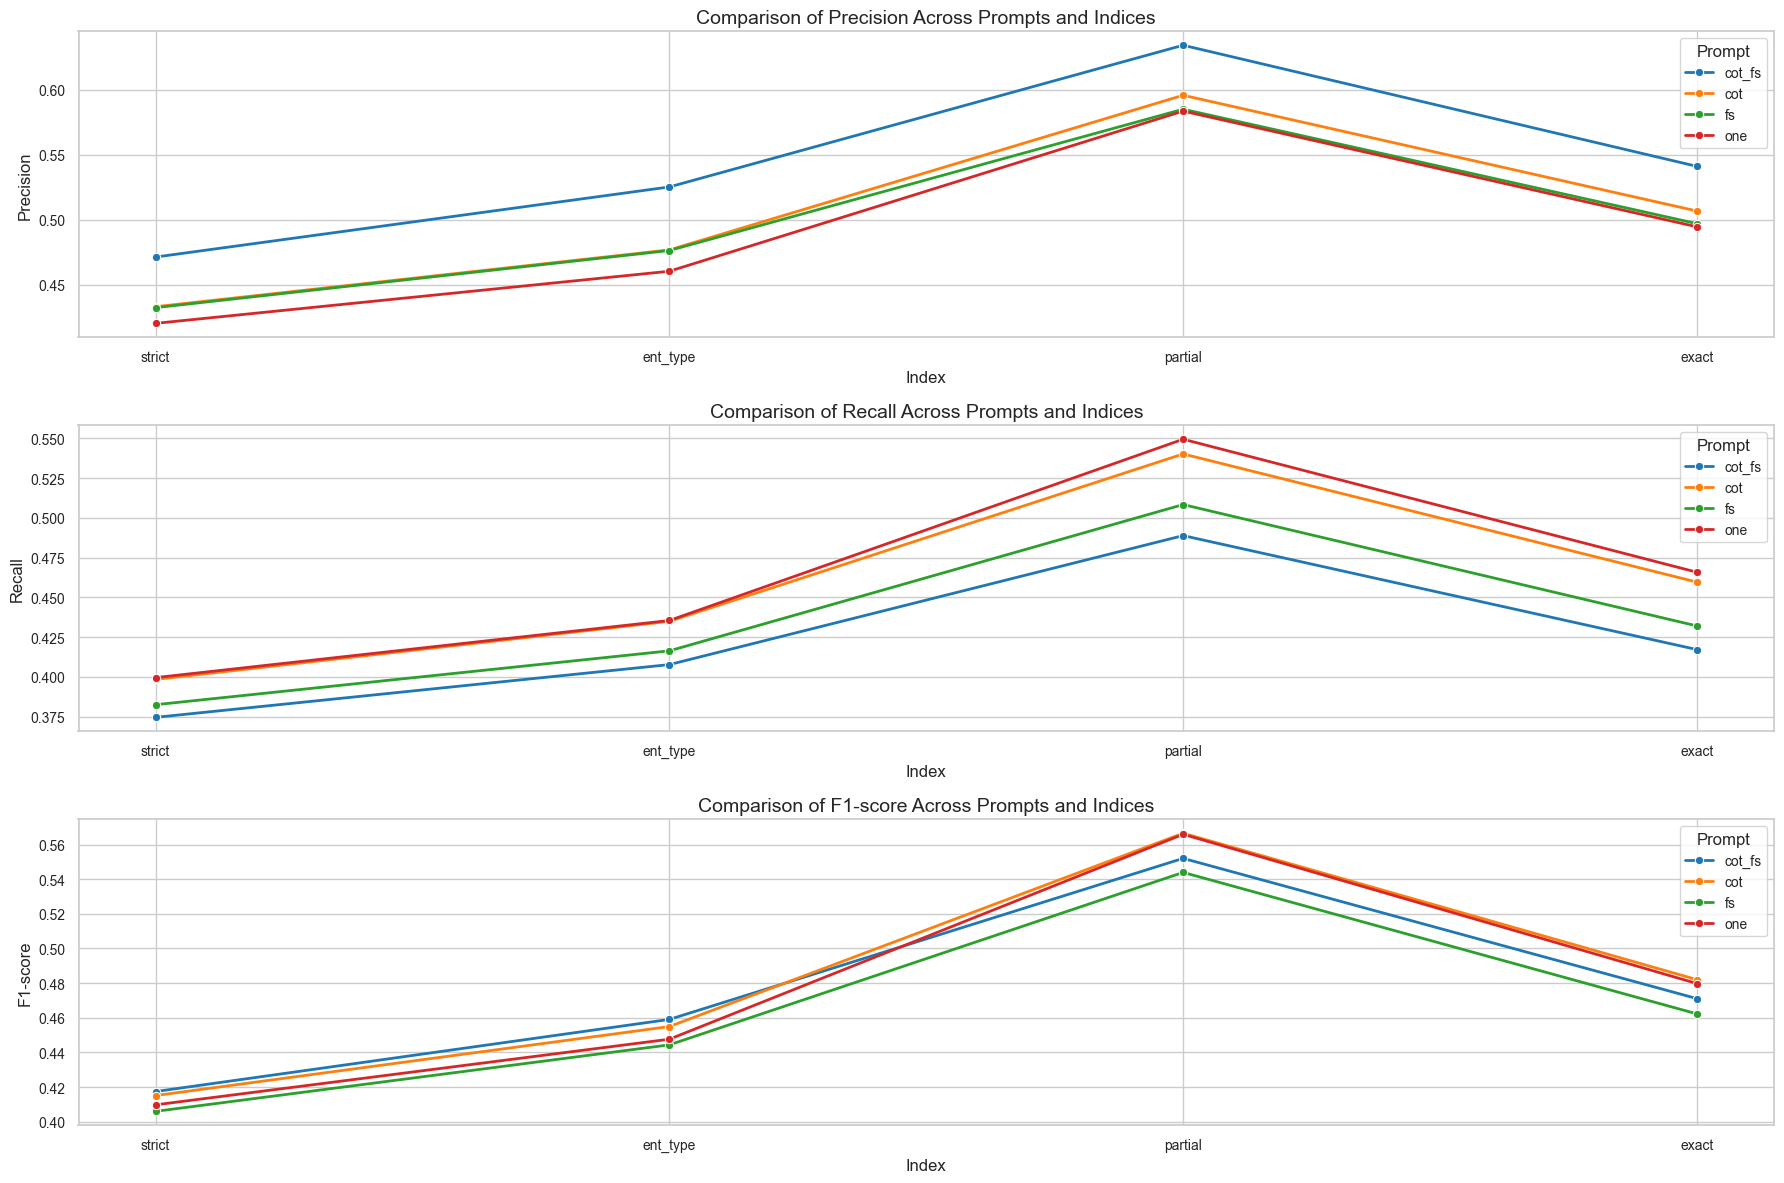

In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Datos
data = {
    "Prompt": ["cot_fs", "cot_fs", "cot_fs", "cot_fs", "cot", "cot", "cot", "cot", 
               "fs", "fs", "fs", "fs", "one", "one", "one", "one"],
    "Index": ["strict", "ent_type", "partial", "exact", "strict", "ent_type", "partial", "exact",
              "strict", "ent_type", "partial", "exact", "strict", "ent_type", "partial", "exact"],
    'Precision': [0.471401335, 0.525225704, 0.634026258, 0.541028446, 
                  0.433278, 0.476881, 0.595617, 0.506744, 
                  0.432548, 0.476415, 0.584892, 0.497047, 
                  0.420486, 0.460498, 0.583451, 0.494609],
    'Recall': [0.374479364, 0.407666941, 0.488823281, 0.417123577, 
               0.398334, 0.43489, 0.540192, 0.459589, 
               0.382431, 0.416323, 0.50834, 0.431993, 
               0.39947, 0.435411, 0.549448, 0.465784],
    'F1-score': [0.417387635, 0.45903922, 0.552036199, 0.471064539, 
                 0.415072, 0.454919, 0.566552, 0.482016, 
                 0.405949, 0.444347, 0.543936, 0.462243, 
                 0.409709, 0.447603, 0.565939, 0.479764]
}

# Convertir a DataFrame
df = pd.DataFrame(data)

# Configurar estilo de Seaborn
sns.set(style="whitegrid")

# Generar gráficos individuales para Precision, Recall y F1-score
metrics = ["Precision", "Recall", "F1-score"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

plt.figure(figsize=(18, 12))

for i, metric in enumerate(metrics, start=1):
    plt.subplot(3, 1, i)
    sns.lineplot(data=df, x="Index", y=metric, hue="Prompt", marker="o", palette="tab10", linewidth=2)
    plt.title(f"Comparison of {metric} Across Prompts and Indices", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Prompt", fontsize=10, loc='best')
    plt.grid(True)

# Ajustar y mostrar
plt.tight_layout()
plt.show()


In [176]:
from scipy.stats import ttest_ind

# Prueba t para Precision
t_stat, p_value = ttest_ind(
    df[df['Century'] == 17]['Precision'],
    df[df['Century'] == 18]['Precision']
)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -4.0378642654362435, P-value: 0.0068192015078009085


In [ ]:
!pip install scikit_posthocs

In [22]:

 
def pinta_violin (analiza,campo,grupo):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    outliers = analiza[analiza[campo] > 1]
    if outliers.empty:
        print(f"NO hay Valores mayores a 1:\n")
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=analiza,
        x=grupo,
        y=campo,
        hue=grupo,  # Asigna `Century` a `hue` para que la paleta funcione correctamente
        palette="Set2",
        linewidth=2, 
        #inner="quartile",
        dodge=False,    # Evita que se separe por categorías del hue
        legend=False    # Desactiva la leyenda
    )
    #sns.violinplot(x='Century', y='PERSON_strict_F1', data=persona, palette='muted', inner='quartile')
    medianas = analiza.groupby(grupo)[campo].median()
    medias= analiza.groupby(grupo)[campo].mean()
    print('Medianas',medianas)
    print('Medias',medias)
    for i, median in enumerate(medianas):
        plt.scatter(i, median, color="red", s=50, zorder=5, label="Median" if i == 0 else "")
    for i, media in enumerate(medias):
        plt.scatter(i, media, color="blue", s=50, zorder=5, label="Media" if i == 0 else "")

    # Personalizar el gráfico
    #plt.legend(loc="upper left")
    plt.ylim(0, 1)
    plt.title('Group Distribution', fontsize=14)
    plt.xlabel(grupo, fontsize=12)
    plt.ylabel(campo, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.show()

In [ ]:
!pip install plotly

In [20]:
import plotly.express as px
import pandas as pd

def pinta_violin_plotly(analiza, campo, grupo):
    """
    Dibuja diagramas de violín usando plotly.
    
    Args:
        analiza (pd.DataFrame): DataFrame con los datos.
        campo (str): Nombre de la columna que contiene los valores a graficar (eje Y).
        grupo (str): Nombre de la columna que contiene los grupos (eje X).
    """
    # Identificar outliers
    outliers = analiza[analiza[campo] > 1]
    if outliers.empty:
        print(f"NO hay Valores mayores a 1:\n")
    
    # Crear gráfico
    fig = px.violin(
        data_frame=analiza,
        x=grupo,
        y=campo,
        color=grupo,  # Color según el grupo
        box=True,     # Añadir caja de bigotes
        points="all", # Mostrar todos los puntos
        hover_data=analiza.columns,  # Mostrar datos adicionales al pasar el ratón
    )
    
    # Personalizar título y ejes
    fig.update_layout(
        title="Distribución por Grupos",
        xaxis_title=grupo,
        yaxis_title=campo,
        yaxis=dict(range=[0, 1]),  # Ajustar el rango de valores en Y
        legend_title="Grupos",
        template="plotly_white",   # Tema limpio
    )
    
    # Mostrar gráfico
    fig.show()


ModuleNotFoundError: No module named 'plotly'

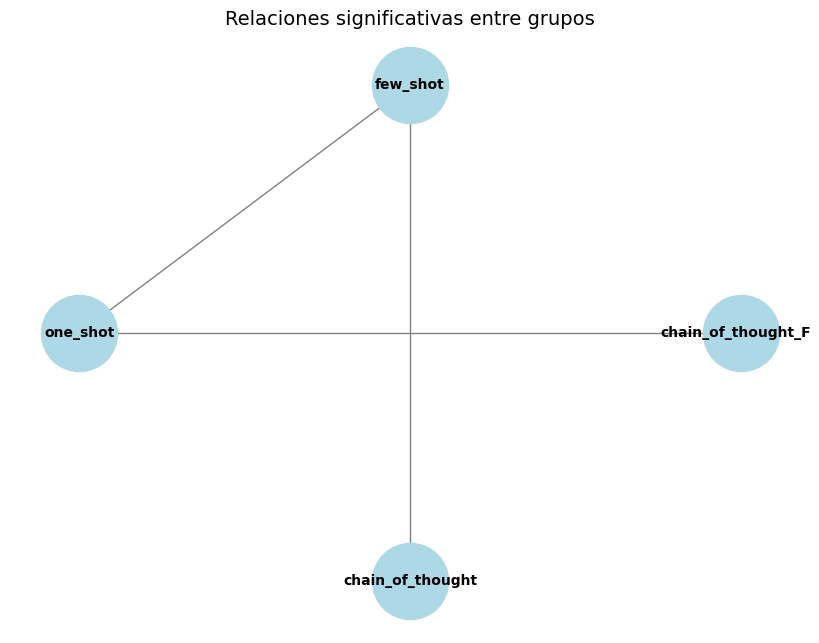

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame de ejemplo (reemplaza con tus datos reales)
data = {
    'score': [0.8, 0.9, 0.7, 0.6, 0.95, 0.88, 0.7, 0.75, 0.85, 0.8, 0.65, 0.7, 0.9],
    'prompt_type': [
        'chain_of_thought_FS', 'chain_of_thought_FS', 'chain_of_thought_FS',
        'few_shot', 'few_shot', 'few_shot',
        'one_shot', 'one_shot', 'one_shot',
        'chain_of_thought', 'chain_of_thought', 'chain_of_thought', 'chain_of_thought'
    ]
}
import networkx as nx

# Crear grafo
G = nx.Graph()

# Añadir nodos (grupos)
grupos = ['chain_of_thought_FS', 'few_shot', 'one_shot', 'chain_of_thought']
G.add_nodes_from(grupos)

# Añadir aristas (comparaciones significativas)
aristas = [
    ('chain_of_thought_FS', 'one_shot'),
    ('chain_of_thought', 'few_shot'),
    ('few_shot', 'one_shot')
]
G.add_edges_from(aristas)

# Dibujar el grafo
plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)  # Distribución circular
nx.draw(
    G, pos, with_labels=True, node_color='lightblue', node_size=3000, 
    font_size=10, font_weight='bold', edge_color='gray'
)
plt.title("Relaciones significativas entre grupos", fontsize=14)
plt.show()


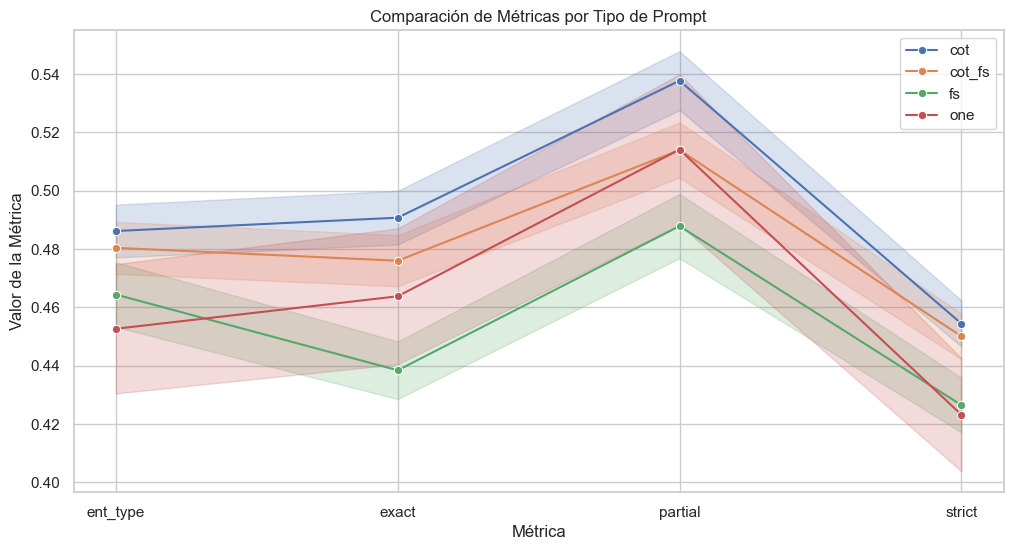

In [244]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datos proporcionados
data = {
    'Prompt': ['cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one',
               'cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one',
               'cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one',
               'cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one'],
    'Metrica': ['ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type',
                'exact', 'exact', 'exact', 'exact', 'exact', 'exact', 'exact', 'exact',
                'partial', 'partial', 'partial', 'partial', 'partial', 'partial', 'partial', 'partial',
                'strict', 'strict', 'strict', 'strict', 'strict', 'strict', 'strict', 'strict'],
    'Valor': [0.495261, 0.477169, 0.489362, 0.471526, 0.453333, 0.475524, 0.474874, 0.430524,
              0.5, 0.481567, 0.484778, 0.467269, 0.428571, 0.448352, 0.487113, 0.440559,
              0.547847, 0.52765, 0.523419, 0.504515, 0.476891, 0.498901, 0.539948, 0.488345,
              0.462389, 0.446581, 0.457965, 0.442308, 0.417178, 0.435897, 0.442623, 0.403846]
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(x='Metrica', y='Valor', hue='Prompt', data=df, marker='o')

# Configurar la leyenda en la esquina superior derecha
plt.legend(loc='upper right')

# Configurar títulos y etiquetas
plt.title('Comparación de Métricas por Tipo de Prompt')
plt.xlabel('Métrica')
plt.ylabel('Valor de la Métrica')
plt.grid(True)
plt.show()


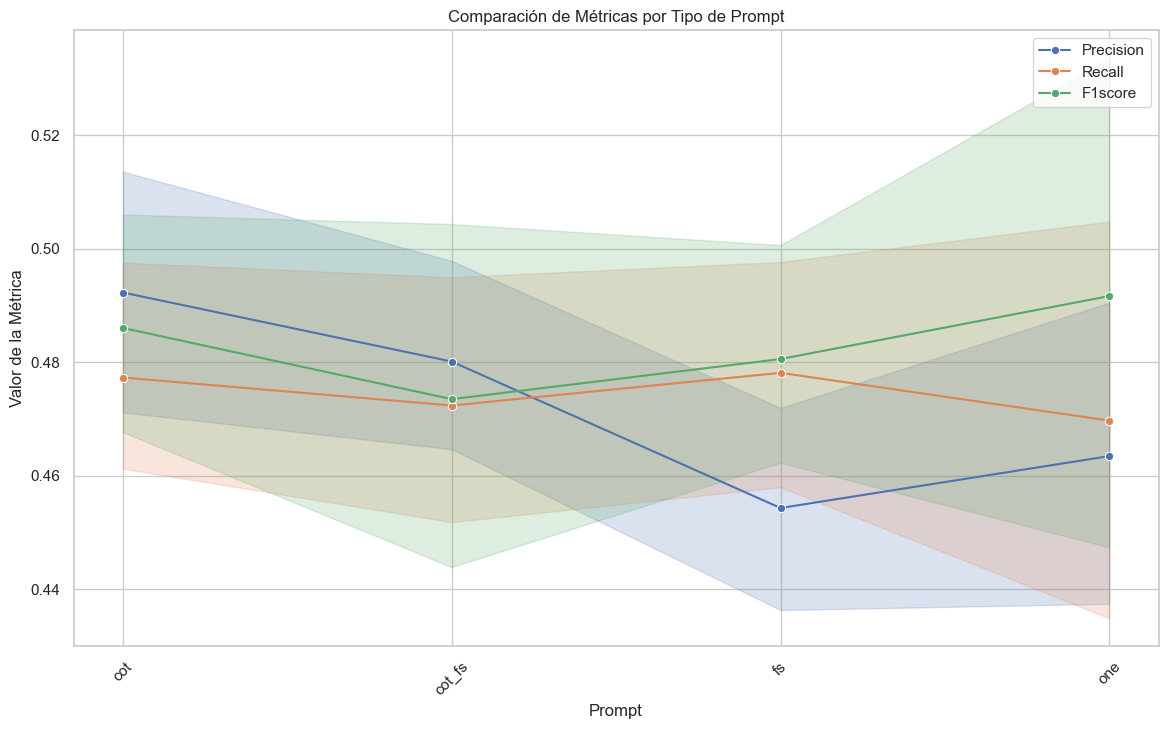

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Datos proporcionados
data = {
    'Prompt': ['cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one',
               'cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one',
               'cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one',
               'cot', 'cot', 'cot_fs', 'cot_fs', 'fs', 'fs', 'one', 'one'],
    'Metrica': ['ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type', 'ent_type',
                'exact', 'exact', 'exact', 'exact', 'exact', 'exact', 'exact', 'exact',
                'partial', 'partial', 'partial', 'partial', 'partial', 'partial', 'partial', 'partial',
                'strict', 'strict', 'strict', 'strict', 'strict', 'strict', 'strict', 'strict'],
    'Precision': [0.495261, 0.477169, 0.489362, 0.471526, 0.453333, 0.475524, 0.474874, 0.430524,
                  0.5, 0.481567, 0.484778, 0.467269, 0.428571, 0.448352, 0.487113, 0.440559,
                  0.547847, 0.52765, 0.523419, 0.504515, 0.476891, 0.498901, 0.539948, 0.488345,
                  0.462389, 0.446581, 0.457965, 0.442308, 0.417178, 0.435897, 0.442623, 0.403846],
    'Recall': [0.477169, 0.471526, 0.471526, 0.467269, 0.475524, 0.471363, 0.440559, 0.430524,
               0.481567, 0.467269, 0.448352, 0.471363, 0.52765, 0.504515, 0.537909, 0.488345,
               0.52765, 0.504515, 0.537909, 0.504515, 0.498901, 0.475524, 0.545999, 0.488345,
               0.446581, 0.442308, 0.442308, 0.435897, 0.435897, 0.435897, 0.403846, 0.422346],
    'F1score': [0.486047, 0.480278, 0.464164, 0.451613, 0.464164, 0.4632, 0.462668, 0.451613,
                0.49061, 0.475862, 0.438238, 0.483917, 0.537559, 0.513793, 0.561024, 0.512852,
                0.537559, 0.513793, 0.561024, 0.523793, 0.487648, 0.4632, 0.560541, 0.560541,
                0.454348, 0.45, 0.454348, 0.411036, 0.452456, 0.462662, 0.422346, 0.401929]
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Configurar el estilo del gráfico
sns.set(style="whitegrid")

# Graficar cada métrica con líneas
plt.figure(figsize=(14, 8))

# Trazar líneas para cada métrica
for metric in ['Precision', 'Recall', 'F1score']:
    sns.lineplot(x='Prompt', y=metric, data=df, marker='o', label=metric)

# Configurar leyenda en la esquina superior derecha
plt.legend(loc='upper right')

# Títulos y etiquetas
plt.title('Comparación de Métricas por Tipo de Prompt')
plt.xlabel('Prompt')
plt.ylabel('Valor de la Métrica')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()


In [248]:
data_person_19={
    "Prompt": ["cot_fs", "cot", "fs", "one"],
    "strict": {
        "Precision": [0.510067114, 0.516408, 0.479062, 0.507909],
        "Recall": [0.484848485, 0.476874, 0.45614, 0.460925],
        "F1-score": [0.497138185, 0.495854, 0.46732, 0.483278],
    },
    "partial": {
        "Precision": [0.567826087, 0.588448, 0.533679, 0.573126],
        "Recall": [0.538778878, 0.541528, 0.507389, 0.518182],
        "F1-score": [0.552921253, 0.564014, 0.520202, 0.544271],
    },
    "exact": {
        "Precision": [0.528695652, 0.539711, 0.493955, 0.528336],
        "Recall": [0.501650165, 0.496678, 0.469622, 0.477686],
        "F1-score": [0.514817951, 0.517301, 0.481481, 0.501736],
    },
    "ent_type": {
        "Precision": [0.543828265, 0.559925, 0.513465, 0.544256],
        "Recall": [0.515254237, 0.513746, 0.487223, 0.490662],
        "F1-score": [0.529155788, 0.535842, 0.5, 0.516071],
    },
}

In [ ]:
data_person_18 = {
    "Prompt": ["cot", "cot_fs", "fs", "one"],
    "strict": {
        "Precision": [0.462389, 0.457965, 0.417178, 0.442623],
        "Recall": [0.446581, 0.442308, 0.435897, 0.403846],
        "F1-score": [0.454348, 0.45, 0.426332, 0.422346],
    },
    "partial": {
        "Precision": [0.547847, 0.523419, 0.476891, 0.539948],
        "Recall": [0.52765, 0.504515, 0.498901, 0.488345],
        "F1-score": [0.537559, 0.513793, 0.487648, 0.512852],
    },
    "exact": {
        "Precision": [0.5, 0.484778, 0.428571, 0.487113],
        "Recall": [0.481567, 0.467269, 0.448352, 0.440559],
        "F1-score": [0.49061, 0.475862, 0.438238, 0.462668],
    },
    "ent_type": {
        "Precision": [0.495261, 0.489362, 0.453333, 0.474874],
        "Recall": [0.477169, 0.471526, 0.475524, 0.430524],
        "F1-score": [0.486047, 0.480278, 0.464164, 0.451613],
    },
}

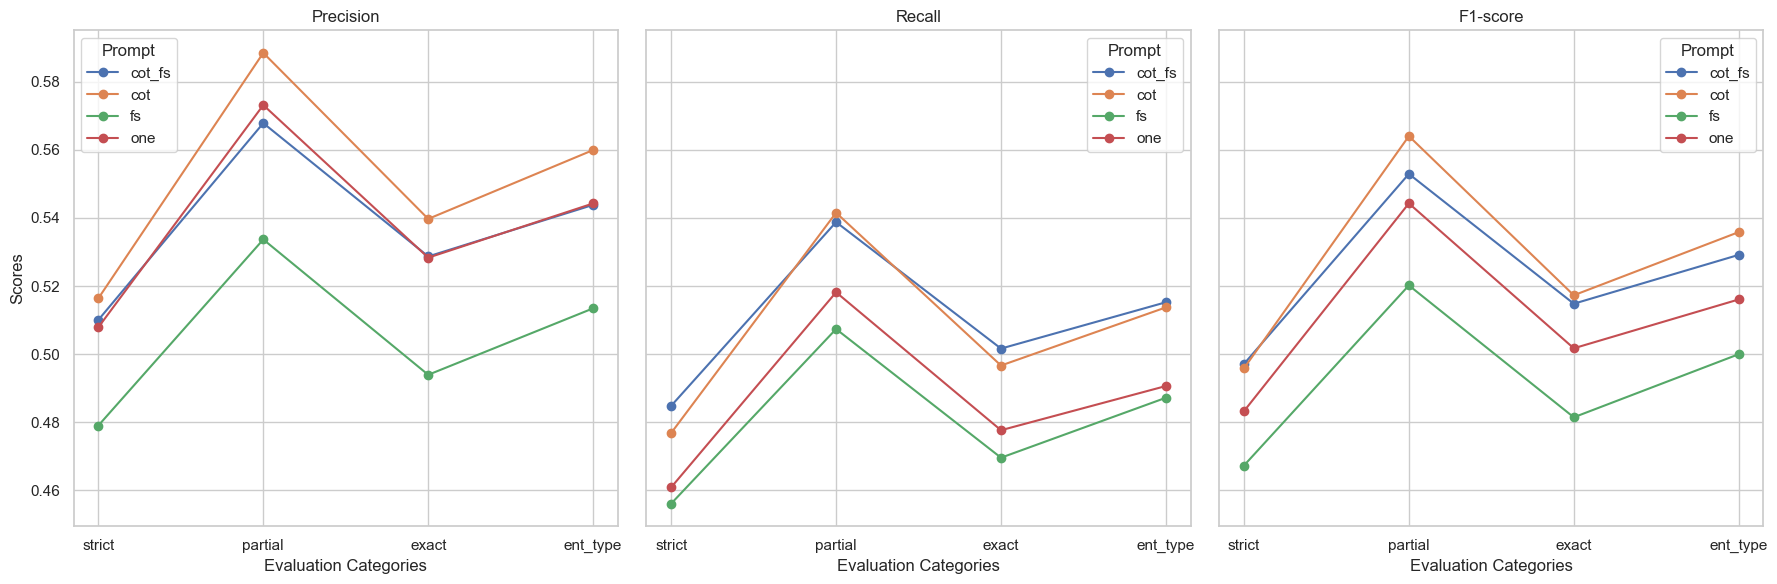

In [249]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos
data = data_person_19

# Graficar
metrics = ["Precision", "Recall", "F1-score"]
categories = ["strict", "partial", "exact", "ent_type"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics):
    for prompt in data["Prompt"]:
        values = [data[cat][metric][data["Prompt"].index(prompt)] for cat in categories]
        axes[i].plot(categories, values, marker='o', label=prompt)
    axes[i].set_title(metric)
    axes[i].set_xlabel("Evaluation Categories")
    axes[i].set_xticks(categories)
    axes[i].legend(title="Prompt")
    if i == 0:
        axes[i].set_ylabel("Scores")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Cargar el archivo Excel
file_path = 'archivo.xlsx'  # Cambia a la ruta de tu archivo
df = pd.read_excel(file_path)

# Crear el diccionario en el formato requerido
data = {
    "Prompt": df['prompt'].unique().tolist(),
    "strict": {
        "Precision": df[df['METRICA'] == 'strict']['Precision'].tolist(),
        "Recall": df[df['METRICA'] == 'strict']['Recall'].tolist(),
        "F1-score": df[df['METRICA'] == 'strict']['F1-score'].tolist(),
    },
    "partial": {
        "Precision": df[df['METRICA'] == 'partial']['Precision'].tolist(),
        "Recall": df[df['METRICA'] == 'partial']['Recall'].tolist(),
        "F1-score": df[df['METRICA'] == 'partial']['F1-score'].tolist(),
    },
    "exact": {
        "Precision": df[df['METRICA'] == 'exact']['Precision'].tolist(),
        "Recall": df[df['METRICA'] == 'exact']['Recall'].tolist(),
        "F1-score": df[df['METRICA'] == 'exact']['F1-score'].tolist(),
    },
    "ent_type": {
        "Precision": df[df['METRICA'] == 'ent_type']['Precision'].tolist(),
        "Recall": df[df['METRICA'] == 'ent_type']['Recall'].tolist(),
        "F1-score": df[df['METRICA'] == 'ent_type']['F1-score'].tolist(),
    },
}

# Imprimir el diccionario resultante
print(data)

In [ ]:


#calcula la precision ,recall y F1 general parametro a de evaluator.
#genera un fichero excel para cada prompt
for valor in valores:
    res_ok=pd.read_csv(f'/Users/salvador/GitHub/absa-travelogues/ABSA_data_ok/resultado_ok_century/normalizado_{valor}_english_fin_ok.csv')
    true = res_ok["gold_labels"].to_list()
    true1=[ast.literal_eval(string) for string in true]
    #Predicted is the model answer for ASPECT
    #predicted = res_ok["ASPECT"].to_list()
    #predicted1=[string.split(',') for string in predicted]

    #Predicted is the model answer for CATEGORY ASPECT
    predicted_cat=res_ok["CAT_ASPECT"].to_list()
    predicted_cat1=[string.split(',') for string in  predicted_cat]
    predicted_cat2=[[valores_a_modificar.get(valor, valor) for valor in sublista] for sublista in predicted_cat1]
    #NERVALUATE 0.2.2
    #a general results
    #b category results
    #c general index
    #d category index
    evaluator = Evaluator(true1, predicted_cat2, tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER'], loader="list")
    a,b,c,d =evaluator.evaluate()
    re_1=prec_recall_total(c)
    re_2=prec_recall_cat(d)

    Totales=pd.DataFrame(re_1)
    #Totales_cat=pd.DataFrame(re_2)
    Totales_cat=pd.DataFrame.from_dict({(entity, eval_type): metrics 
                                for entity, evaluations in re_2.items() 
                                for eval_type, metrics in evaluations.items()})

    Totales_1= Totales.transpose()
    Totales_cat_1=Totales_cat.transpose()
    Totales_1 = Totales_1.reset_index()
    Totales_cat_1 = Totales_cat_1.reset_index()
    Totales_1.to_excel(path+f"total_20_19_18_{valor}.xlsx", index=False)
    Totales_cat_1.to_excel(path+f"total_cat_20_19_18_{valor}.xlsx", index=False)
    for century_value in century:
        true_cent=res_ok.query('Century == @century_value')['gold_labels'].tolist()
        true_cent_1=[ast.literal_eval(string) for string in true_cent]

        #predicted_cent=res_ok.query('Century == @century_value')['ASPECT'].tolist()
        #predicted_cent_1=[string.split(',') for string in predicted_cent]

        predicted_cent_cat=res_ok.query('Century == @century_value')['CAT_ASPECT'].tolist()
        predicted_cent_cat_1=[string.split(',') for string in  predicted_cent_cat]
        predicted_cent_cat_2=[[valores_a_modificar.get(valor, valor) for valor in sublista] for sublista in predicted_cent_cat_1]
        evaluator_cent = Evaluator(true_cent_1, predicted_cent_cat_2, tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER'], loader="list")
        a_cent,b_cent,c_cent,d_cent =evaluator_cent.evaluate()
        re_1=prec_recall_total(c_cent)
        re_2=prec_recall_cat(d_cent)
        
        Totales_cent=pd.DataFrame(re_1)
        Totales_cent_1= Totales_cent.transpose()
        Totales_cent_1 = Totales_cent_1.reset_index()
        Totales_cent_1.to_excel(path+f"total_cent_{century_value}_{valor}.xlsx", index=False)

        
        Totales_cent_cat = pd.DataFrame.from_dict({(entity, eval_type): metrics 
                                    for entity, evaluations in re_2.items() 
                                    for eval_type, metrics in evaluations.items()})
        Totales_cent_cat1= Totales_cent_cat.transpose()
        Totales_cent_cat1 = Totales_cent_cat1.reset_index()
        Totales_cent_cat1.to_excel(path+f"cent_{century_value}_{valor}.xlsx", index=False)
    

## CODIGO DE RESERVA

In [ ]:
# PARA LAS CATEGORIAS calculo ficheros con la informacion de precision ,recall y f1 por categorias y metricas y añado campo categoria para poder agrupar.
valores=['chain_of_thought_FS',
'chain_of_thought',
'few_shot',
'one_shot']
valores_a_modificar={
        "I-WEATHER_PHENOMENA":'I-WEATHER',
        "I-BIOMES": "I-BIOME", 
        "I-MYTHOLOGICAL_ENTITIES":'I-MYTH',
        "I-HUMAN_LANDFORM": 'I-HUM_LANDFORM',
        "I-NATURAL_LANDFORM": 'I-NAT_LANDFORM',
        "I-NATURAL_PHENOMENON":'I-NAT_PHENOMENON',
        "B-WEATHER_PHENOMENA":'B-WEATHER',
        "B-BIOMES": "B-BIOME", 
        "B-MYTHOLOGICAL_ENTITIES":'B-MYTH',
        "B-HUMAN_LANDFORM": 'B-HUM_LANDFORM',
        "B-NATURAL_LANDFORM": 'B-NAT_LANDFORM',
        "B-NATURAL_PHENOMENON":'B-NAT_PHENOMENON',
        }
for valor in valores:
    res_ok=pd.read_csv(f'/Users/salvador/GitHub/absa-travelogues/ABSA_data_ok/resultado_ok_century/normailizado_{valor}_english_fin_ok.csv')
    prueba=res_ok
    true = res_ok["gold_labels"].to_list()
    true1=[ast.literal_eval(string) for string in true]
    #Predicted is the model answer for CATEGORY ASPECT
    predicted_cat=res_ok["CAT_ASPECT"].to_list()
    predicted_cat1=[string.split(',') for string in  predicted_cat]
    predicted_cat2=[[valores_a_modificar.get(valor, valor) for valor in sublista] for sublista in predicted_cat1]
    cuenta=0
    for linea1 in true1:  
        linea_ok=[]
        linea_ok.append(linea1)
        linea_pre=[]
        linea_pre.append(predicted_cat2[cuenta])
        evaluator = Evaluator(linea_ok, linea_pre, tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER'], loader="list")
        a,b,c,d =evaluator.evaluate()
        re_2=prec_recall_cat(d)
        for categoria, sublista in re_2.items():
            for valor1,metricas in sublista.items():
                dato_precision=re_2.get(categoria, {}).get(valor1, {}).get('Precision', None)
                dato_recall=re_2.get(categoria, {}).get(valor1, {}).get('Recall', None)
                dato_f1=re_2.get(categoria, {}).get(valor1, {}).get('F1-score', None)
                actual_1=re_2.get(categoria, {}).get(valor1, {}).get('actual', None)
                posible_1=re_2.get(categoria, {}).get(valor1, {}).get('posible', None)
                if actual_1 or posible_1:
                    prueba.loc[cuenta, f'{categoria}'] =categoria
                else:
                    prueba.loc[cuenta, f'{categoria}'] ='NONE'
                prueba.loc[cuenta, f'{categoria}_{valor1}_Precision_'] = dato_precision
                prueba.loc[cuenta, f'{categoria}_{valor1}_Recall]'] = dato_recall
                prueba.loc[cuenta, f'{categoria}_{valor1}_F1'] =dato_f1
                
                
        cuenta +=1
        print(cuenta)
    cadena=f'/Users/salvador/GitHub/absa-travelogues/ABSA_data_ok/resultado_ok_century/categoria_normalizado_{valor}_english_fin_ok.csv'
    prueba.to_csv(cadena, index=False)

## OLD NOT USE 

In [ ]:

# ESTE CODIGO LO USE PARA GENERAR LAS PRIMERAS EXCEL PERO ESTABN MAL LAS METRICAS Y LAS RECALCULE en otro codigo
# LOAD DE DATA AND CONVERT TO LIST OF LISTS
# CARGO LOS DATOS Y LO CONVIERTO EN LISTA DE LISTAS
#OJO QUE HAY DOS FORMATOS DIFERENTES EL TRUE Y EL RESTO

#PARA EVALUAR TODOS

#True is the gold labels
path='/Users/salvador/GitHub/absa-travelogues/ABSA_data_ok/resultado_ok_century/'
century=[20,19,18]
valores=['chain_of_thought_FS',
'chain_of_thought',
'few_shot',
'one_shot']
valores_a_modificar={
        "I-WEATHER_PHENOMENA":'I-WEATHER',
        "I-BIOMES": "I-BIOME", 
        "I-MYTHOLOGICAL_ENTITIES":'I-MYTH',
        "I-HUMAN_LANDFORM": 'I-HUM_LANDFORM',
        "I-NATURAL_LANDFORM": 'I-NAT_LANDFORM',
        "I-NATURAL_PHENOMENON":'I-NAT_PHENOMENON',
        "B-WEATHER_PHENOMENA":'B-WEATHER',
        "B-BIOMES": "B-BIOME", 
        "B-MYTHOLOGICAL_ENTITIES":'B-MYTH',
        "B-HUMAN_LANDFORM": 'B-HUM_LANDFORM',
        "B-NATURAL_LANDFORM": 'B-NAT_LANDFORM',
        "B-NATURAL_PHENOMENON":'B-NAT_PHENOMENON',
        }

for valor in valores:
    res_ok=pd.read_csv(f'/Users/salvador/GitHub/absa-travelogues/ABSA_data_ok/resultado_ok_century/normailizado_{valor}_english_fin_ok.csv')
    true = res_ok["gold_labels"].to_list()
    true1=[ast.literal_eval(string) for string in true]
    #Predicted is the model answer for ASPECT
    predicted = res_ok["ASPECT"].to_list()
    predicted1=[string.split(',') for string in predicted]

    #Predicted is the model answer for CATEGORY ASPECT
    predicted_cat=res_ok["CAT_ASPECT"].to_list()
    predicted_cat1=[string.split(',') for string in  predicted_cat]
    predicted_cat2=[[valores_a_modificar.get(valor, valor) for valor in sublista] for sublista in predicted_cat1]
    #NERVALUATE 0.2.2
    #a general results
    #b category results
    #c general index
    #d category index
    evaluator = Evaluator(true1, predicted_cat2, tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER'], loader="list")
    a,b,c,d =evaluator.evaluate()
    re_1=prec_recall_total(c)
    re_2=prec_recall_cat(d)
    
    Totales=pd.DataFrame(re_1)
    #Totales_cat=pd.DataFrame(re_2)
    Totales_cat=pd.DataFrame.from_dict({(entity, eval_type): metrics 
                                    for entity, evaluations in re_2.items() 
                                    for eval_type, metrics in evaluations.items()})
    
    Totales_1= Totales.transpose()
    Totales_cat_1=Totales_cat.transpose()
    Totales_1 = Totales_1.reset_index()
    Totales_cat_1 = Totales_cat_1.reset_index()
    Totales_1.to_excel(path+f"total_20_19_18_{valor}.xlsx", index=False)
    Totales_cat_1.to_excel(path+f"total_cat_20_19_18_{valor}.xlsx", index=False)
    for century_value in century:
        true_cent=res_ok.query('Century == @century_value')['gold_labels'].tolist()
        true_cent_1=[ast.literal_eval(string) for string in true_cent]

        predicted_cent=res_ok.query('Century == @century_value')['ASPECT'].tolist()
        predicted_cent_1=[string.split(',') for string in predicted_cent]

        predicted_cent_cat=res_ok.query('Century == @century_value')['CAT_ASPECT'].tolist()
        predicted_cent_cat_1=[string.split(',') for string in  predicted_cent_cat]
        predicted_cent_cat_2=[[valores_a_modificar.get(valor, valor) for valor in sublista] for sublista in predicted_cent_cat_1]
        evaluator_cent = Evaluator(true_cent_1, predicted_cent_cat_2, tags=['PERSON', 'LOCATION','FAUNA','FLORA', 'WEATHER', 'ORGANISATION','BIOME','MYTH','HUM_LANDFORM','NAT_LANDFORM','NAT_PHENOMENON','LAND_COVER'], loader="list")
        a_cent,b_cent,c_cent,d_cent =evaluator_cent.evaluate()
        re_1=prec_recall_total(c_cent)
        re_2=prec_recall_cat(d_cent)
        
        Totales_cent=pd.DataFrame(re_1)
        Totales_cent_1= Totales_cent.transpose()
        Totales_cent_1 = Totales_cent_1.reset_index()
        Totales_cent_1.to_excel(path+f"total_cent_{century_value}_{valor}.xlsx", index=False)
    
        
        Totales_cent_cat = pd.DataFrame.from_dict({(entity, eval_type): metrics 
                                    for entity, evaluations in re_2.items() 
                                    for eval_type, metrics in evaluations.items()})
        Totales_cent_cat1= Totales_cent_cat.transpose()
        Totales_cent_cat1 = Totales_cent_cat1.reset_index()
        Totales_cent_cat1.to_excel(path+f"cent_{century_value}_{valor}.xlsx", index=False)
        
